In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from scipy.stats import chi2_contingency
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [2]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [3]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

In [4]:
climate_classifications = pd.read_csv("data/climate_classified.csv")
climate_classifications.set_index("climate", inplace=True)

,scheme,seasonal_precipitation,heat_level
climate,,,
Cfa,Temperate,without dry season,hot summer
Dfb,Continental,without dry season,warm summer
Dfa,Continental,without dry season,hot summer
Csa,Temperate,with dry season,hot summer
Dsb,Continental,with dry season,warm summer
Dfc,Continental,without dry season,cold summer
Csb,Temperate,with dry season,warm summer
Bsk,Dry,with dry season,cold summer
Cfb,Temperate,without dry season,warm summer


# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


## 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.



In [5]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## Is focusing on the US a feasible idea ?

### Numerical reviews

Here we want only the revieys of users in the US and then drop the beers with less than 10 reviews and see how many reviews per state there is after it.

 Percentage of ratings left:  95.64330429185075 %


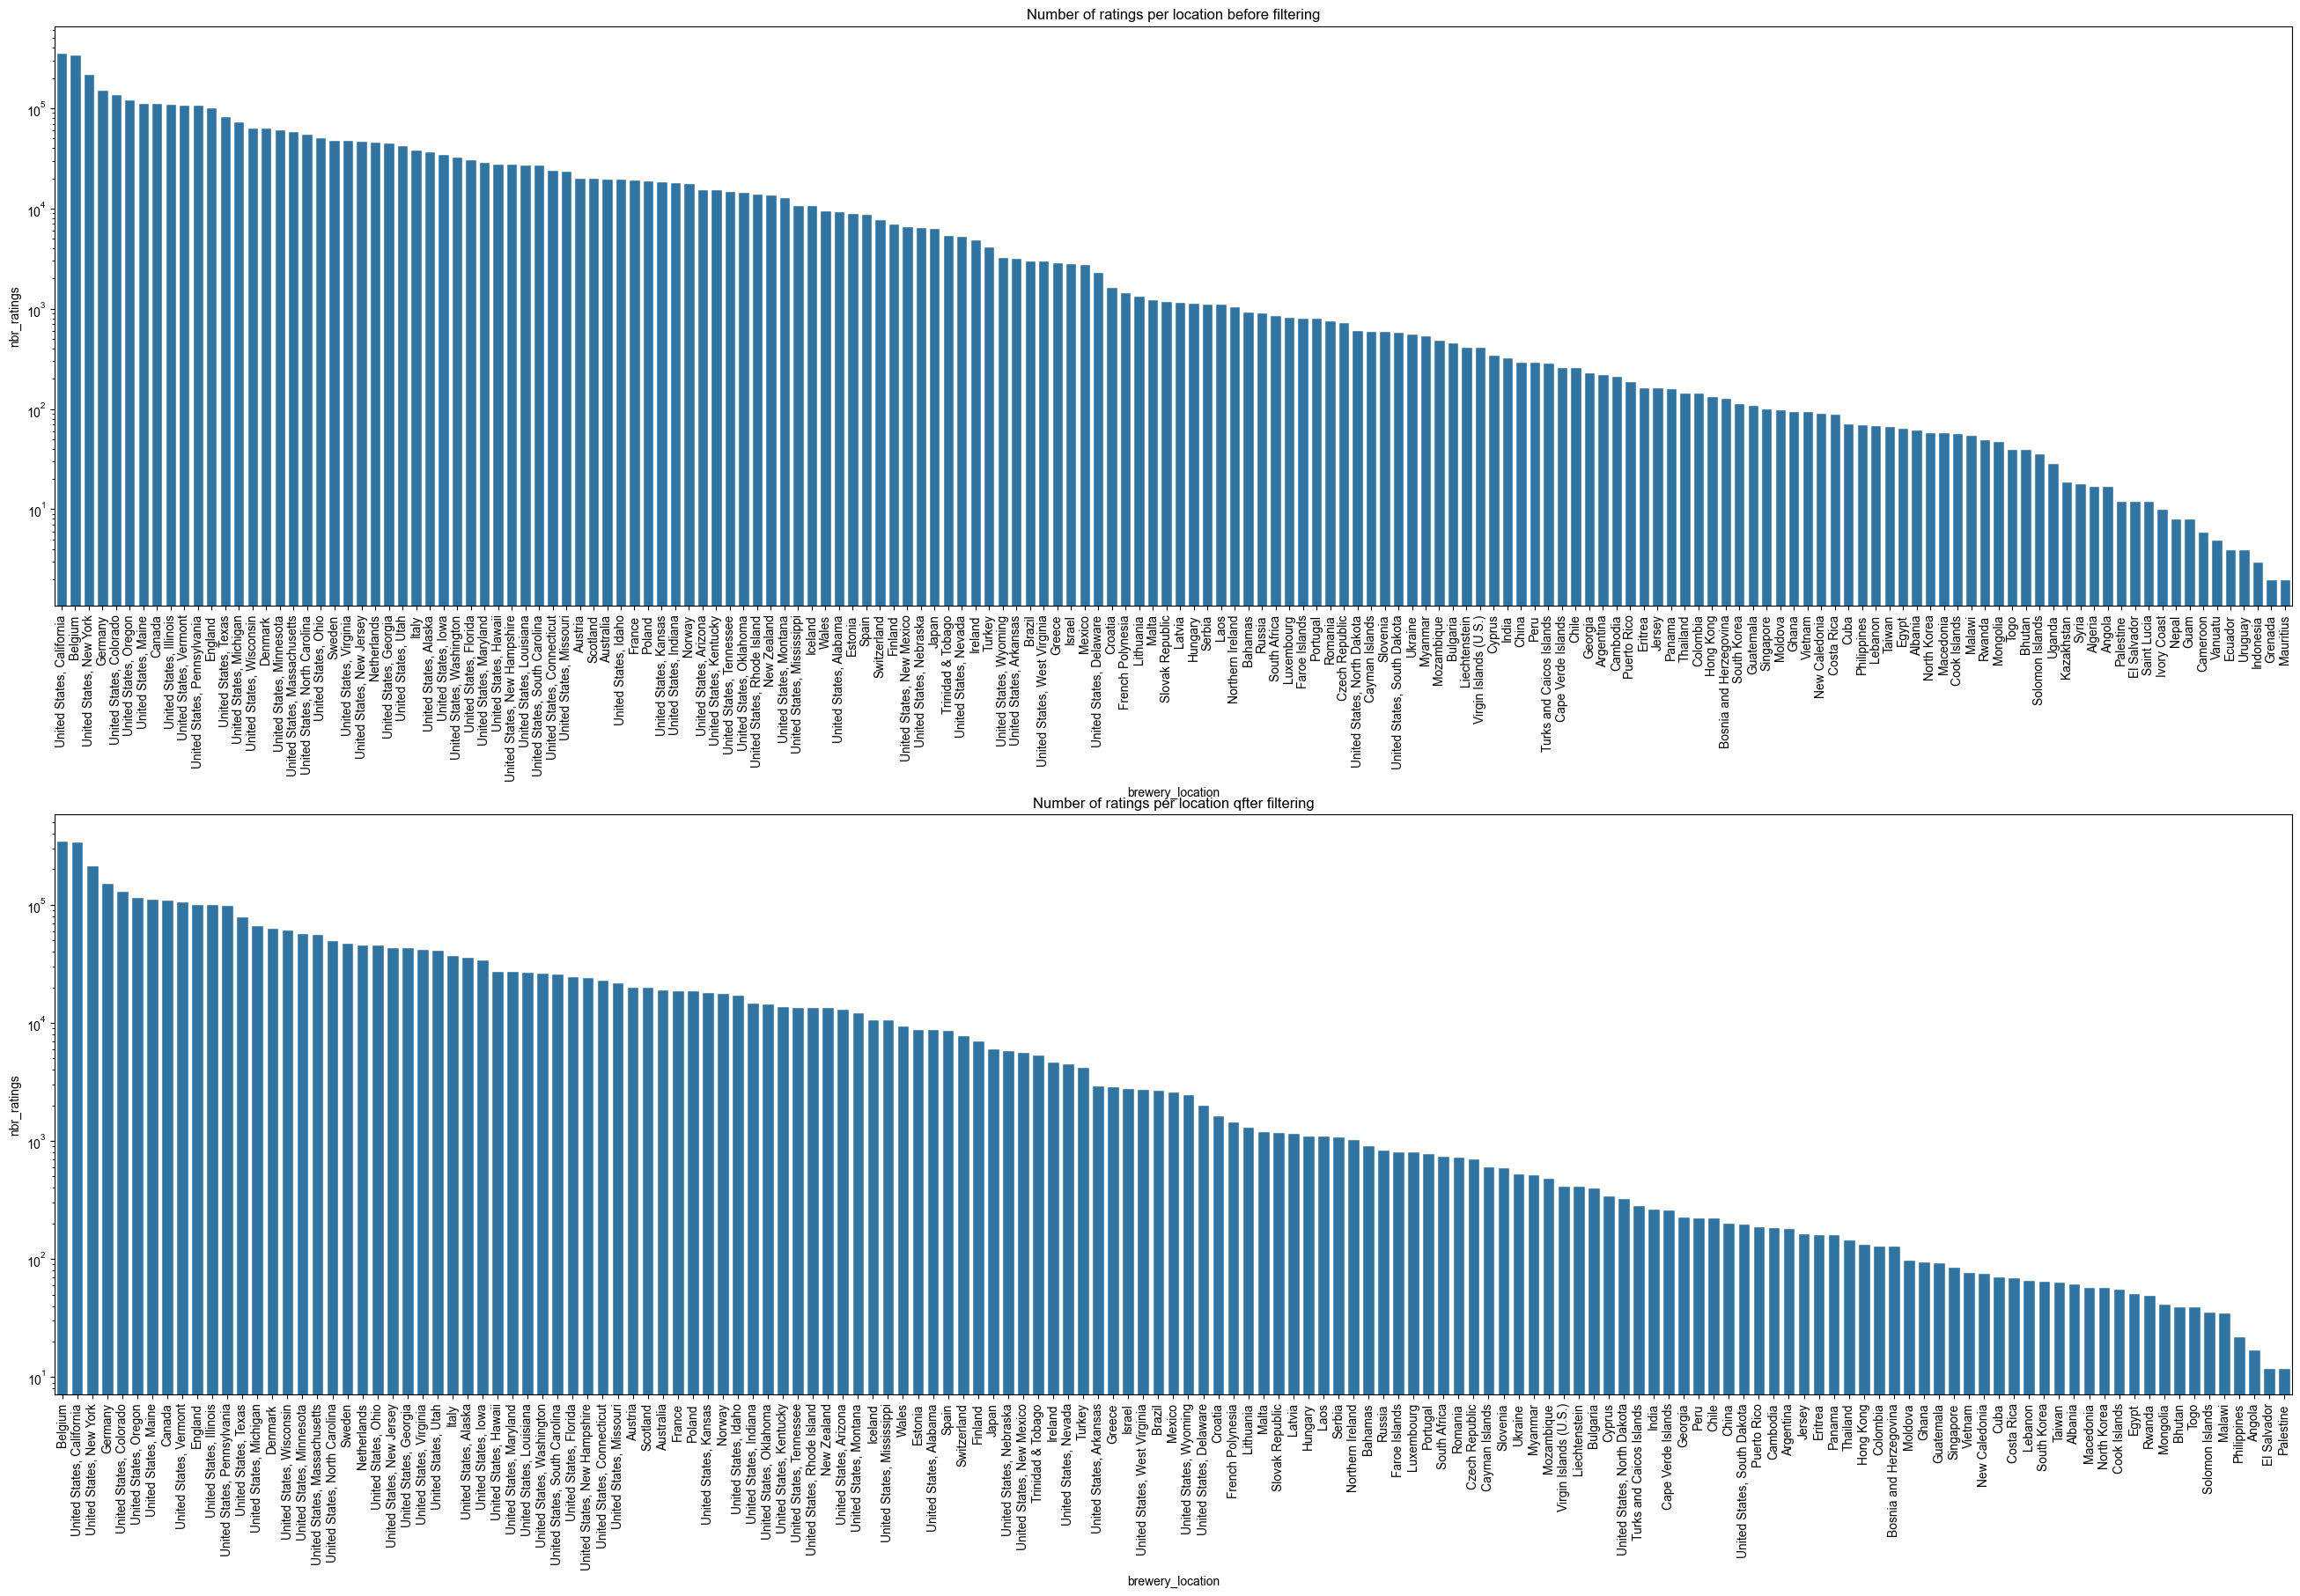

In [7]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]

world_ratings = world_ratings.dropna(subset=["user_location"])

#create df with only users from the us & remove duplicates
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_ratings = us_users_ratings.loc[:, ~us_users_ratings.columns.duplicated()]

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

unique_beers = us_users_ratings[["beer_id", "nbr_ratings", "brewery_location"]].copy().drop_duplicates()
total_ratings = unique_beers["nbr_ratings"].sum()

unique_beers = unique_beers.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=unique_beers, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of ratings per location before filtering")
axs[0].set(yscale="log")

#only keep beers with more than 10 ratings
us_users_ratings = us_users_ratings[us_users_ratings["nbr_ratings"] > 10]

us_users_ratings["climate_scheme"] = us_users_ratings["climate"].map(climate_classifications["scheme"])
us_users_ratings["climate_precipitation"] = us_users_ratings["climate"].map(climate_classifications["seasonal_precipitation"])
us_users_ratings["climate_temperature"] = us_users_ratings["climate"].map(climate_classifications["heat_level"])

beers_left = us_users_ratings[["beer_id","nbr_ratings", "brewery_location"]].copy().drop_duplicates()

beers_left = beers_left.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

ratings_left = beers_left["nbr_ratings"].sum()
print(" Percentage of ratings left: ", ratings_left / total_ratings * 100, "%")

beers_left["Percentage of ratings"] = beers_left["nbr_ratings"] / beers_left["nbr_ratings"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=beers_left, orient="v", ax=axs[1])
axs[1].set_title("Number of ratings per location qfter filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")

In [8]:
# For the analysis, drop NaN from the columns of interest
us_users_ratings = us_users_ratings.dropna(subset=["overall", "abv"])

In [10]:
def plot_climate_stats(df, column, title, ax=None, symmetrical=False, categorical=False):
    """
    This function plots on a map of the United States the mean of the column passed as argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes is created.
        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.
        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """
    
    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")
    
    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii
    
    # Plot the map
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")
    
    if symmetrical:
        cmap_name = "RdBu_r"
    elif categorical:
        cmap_name = "tab10"
    else:
        cmap_name = "YlOrRd"
        
    
    us_map_shifted.plot(column=column, cmap=cmap_name, ax=ax, legend=True, missing_kwds={"color": "lightgrey", "label": "Missing values"})
    ax.set_title(title)
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

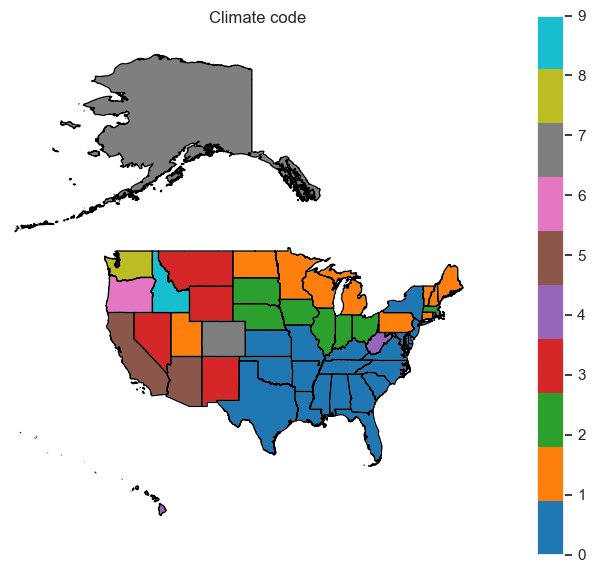

In [11]:
climate_df = pd.DataFrame(columns=["climate", "climate_code"])
climate_df["climate"] = states_climate["Climate"].unique()
climate_df["climate_code"] = range(len(climate_df))

plot_climate_stats(climate_df, "climate_code", "Climate code", categorical=True)

Scheme:
['Temperate' 'Continental' 'Dry']
Seasonal precipitation:
['without dry season' 'with dry season']
Heat level:
['hot summer' 'warm summer' 'cold summer']


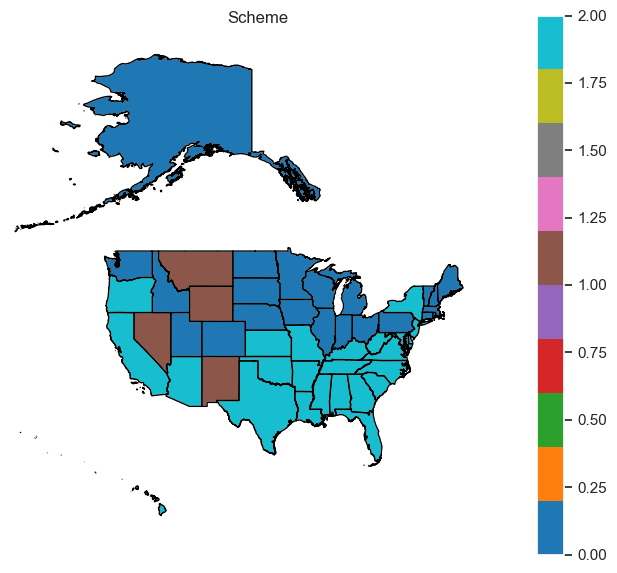

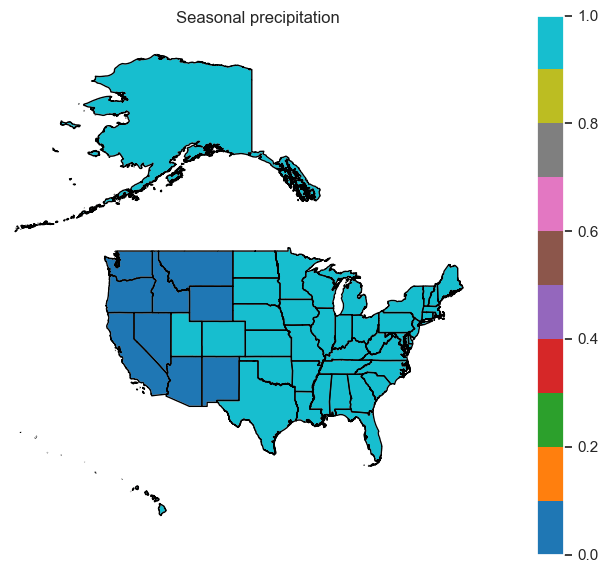

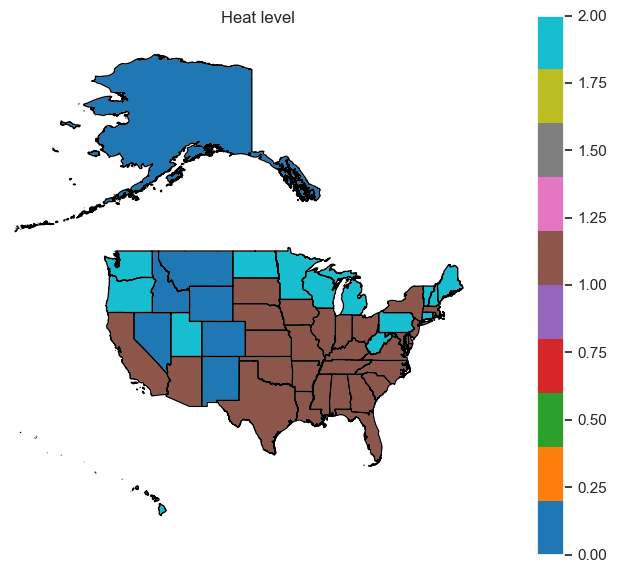

In [12]:
# Plot the 3 level of climate classification

# First turn "scheme", "seasonal_precipitation" and "heat_level" columns into int ids
climate_classifications_plot = climate_classifications.copy()
climate_classifications_plot["scheme"] = climate_classifications_plot["scheme"].astype("category").cat.codes
climate_classifications_plot["seasonal_precipitation"] = climate_classifications_plot["seasonal_precipitation"].astype("category").cat.codes
climate_classifications_plot["heat_level"] = climate_classifications_plot["heat_level"].astype("category").cat.codes

print("Scheme:")
print(climate_classifications["scheme"].unique())
plot_climate_stats(climate_classifications_plot, "scheme", "Scheme", categorical=True)

print("Seasonal precipitation:")
print(climate_classifications["seasonal_precipitation"].unique())
plot_climate_stats(climate_classifications_plot, "seasonal_precipitation", "Seasonal precipitation", categorical=True)

print("Heat level:")
print(climate_classifications["heat_level"].unique())
plot_climate_stats(climate_classifications_plot, "heat_level", "Heat level", categorical=True)

## Add the column *General Style*

In [14]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx")) 
print("There are {} different general beer types".format(len(set(mapping_df['general_style']))))

# extract all general beer types
general_beer_types = list(set(mapping_df['general_style']))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on='style', how='left')
us_users_ratings.head()

There are 10 different general beer types
['Stout', 'Lager', 'Porter', 'Blonde Ale', 'Sour Ale', 'Wheat beer', 'Brown Ale', 'Scottish Ale ', 'IPA', 'Pale Ale']


,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
0,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale
1,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale
2,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa,Continental,without dry season,hot summer,Pale Ale
3,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa,Continental,without dry season,hot summer,Pale Ale
4,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale


## 3) First analysis : Correlation between climate and abv

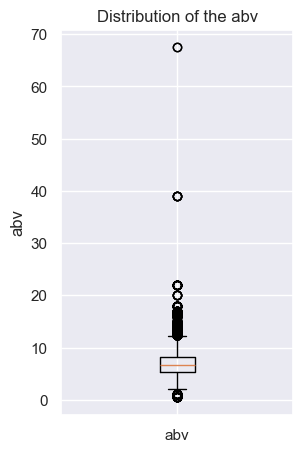

In [120]:
#boxplot of abv of the us
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_users_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()


5th percentile: 4.5
95th percentile: 11.1
Shape before filtering: (228194, 35)
Shape after filtering: (208332, 35)


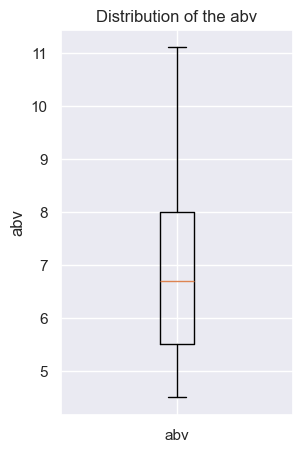

In [128]:
#keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

print("Shape before filtering:", us_users_ratings.shape)
us_abv_ratings = us_users_ratings[(us_users_ratings["abv"] >= quantile_5) & (us_users_ratings["abv"] <= quantile_95)]
print("Shape after filtering:", us_abv_ratings.shape)

# Boxplot of the abv of us_abv_ratings
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_abv_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()


In [124]:
#sort a dataframe with the name ot the climate
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])

#to store the climate dataframes
climate_dataframes = {}

#create a for loop to create separate dataframes for each climate based on the climate_names
for climate in climate_names["climate"]:
    climate_df= pd.DataFrame(us_abv_ratings[us_abv_ratings["climate"] == climate].reset_index(drop=True))
    climate_dataframes[climate] = climate_df.sort_values(by="overall", ascending=False).reset_index(drop=True)

In [138]:
us_abv_means = pd.DataFrame(columns=["climate", "mean_abv_overall", "mean_abv_best", "mean_abv_most"])

for climate in climate_names["climate"]:
    climate_df = us_abv_ratings[us_abv_ratings["climate"] == climate]
    
    # Compute the mean abv for each climate weighted by overall score
    mean_abv_overall = (climate_df["abv"] * climate_df["overall"]).sum() / climate_df["overall"].sum()
    
    us_abv_means.loc[len(us_abv_means)] = [climate, mean_abv_overall, 0.0, 0.0]
    
display(us_abv_means)

,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.966632,0.0,0.0
1,Dfa,6.981634,0.0,0.0
2,Cfb,6.863458,0.0,0.0
3,Dfb,6.915130,0.0,0.0
4,Dfc,6.921801,0.0,0.0
5,Csb,6.838142,0.0,0.0
6,Bsk,6.864243,0.0,0.0
7,Csa,7.062307,0.0,0.0
8,Dsb,6.994122,0.0,0.0
9,Dsc,6.812934,0.0,0.0


In [139]:
keeping_best_beers = {}
count_style_occurences = {}

#create new dataframes containign the best three beers for each climate
for climate, climate_df in climate_dataframes.items():
    us_grouped_beers = climate_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]

    #count the number of occurences of each style of beer
    for beer in best_three.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_best_beers[climate] = climate_df[climate_df["general_style"].isin(best_three.index)].reset_index(drop=True)

print("Number of times a beer style appears in the top 3 beers of a climate: ")
display(count_style_occurences)


Number of times a beer style appears in the top 3 beers of a climate: 


{'Sour Ale': 10, 'IPA': 8, 'Stout': 9, 'Porter': 1, 'Brown Ale': 2}

In [142]:
for climate in keeping_best_beers:
    #calculate the mean of the abv in the column abv of the dataframe 
    mean_abv_best = keeping_best_beers[climate]["abv"].mean()
    us_abv_means.loc[us_abv_means["climate"] == climate, "mean_abv_best"] = mean_abv_best
    
display(us_abv_means)


,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.966632,7.526973,0.0
1,Dfa,6.981634,7.547539,0.0
2,Cfb,6.863458,7.927700,0.0
3,Dfb,6.915130,7.455169,0.0
4,Dfc,6.921801,7.034567,0.0
5,Csb,6.838142,7.093543,0.0
6,Bsk,6.864243,7.374981,0.0
7,Csa,7.062307,7.400948,0.0
8,Dsb,6.994122,7.392067,0.0
9,Dsc,6.812934,7.353158,0.0


In [143]:
keeping_most_reviewed_beers = {}
count_style_occurences = {}

for climate, climate_df in climate_dataframes.items():
    #get number of occurences of each style of beer
    num_reviews = climate_df["general_style"].value_counts()

    #keep only the 3 most reviewed beers
    most_reviewed = num_reviews[:3]

    #count the number of occurences of each style of beer
    for beer in most_reviewed.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_most_reviewed_beers[climate] = climate_df[climate_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)

print("Most reviewed beers for each climate:")
for climate in keeping_most_reviewed_beers:
    print("Climate {}: {}".format(climate, keeping_most_reviewed_beers[climate]["general_style"].unique()))

print("Number of occurences of each style of beer:")
display(count_style_occurences)
    

Most reviewed beers for each climate:
Climate Cfa: ['Brown Ale' 'Pale Ale' 'IPA']
Climate Dfa: ['Brown Ale' 'Pale Ale' 'IPA']
Climate Cfb: ['IPA' 'Lager' 'Pale Ale']
Climate Dfb: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Dfc: ['Brown Ale' 'IPA' 'Pale Ale']
Climate Csb: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Bsk: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Csa: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Dsb: ['Brown Ale' 'IPA' 'Pale Ale']
Climate Dsc: ['Pale Ale' 'IPA' 'Lager']
Number of occurences of each style of beer:


{'IPA': 10, 'Pale Ale': 10, 'Brown Ale': 8, 'Lager': 2}

In [144]:
for climate in keeping_most_reviewed_beers:
    #calculate the mean of the abv in the column abv of the dataframe 
    mean_abv_most = keeping_most_reviewed_beers[climate]["abv"].mean()
    us_abv_means.loc[us_abv_means["climate"] == climate, "mean_abv_most"] = mean_abv_most
    
display(us_abv_means)

,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.966632,7.526973,6.932196
1,Dfa,6.981634,7.547539,6.966462
2,Cfb,6.863458,7.927700,6.659652
3,Dfb,6.915130,7.455169,6.859069
4,Dfc,6.921801,7.034567,6.867535
5,Csb,6.838142,7.093543,6.779279
6,Bsk,6.864243,7.374981,6.845653
7,Csa,7.062307,7.400948,7.032114
8,Dsb,6.994122,7.392067,6.911417
9,Dsc,6.812934,7.353158,6.737406


In [147]:
# One-way ANOVA test for the mean abv of each climate
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate == zone]["abv"]
        for zone in us_abv_ratings.climate.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate
res = stats.f_oneway(
    *[
        keeping_best_beers[zone]["abv"]
        for zone in keeping_best_beers.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate
res = stats.f_oneway(
    *[
        keeping_most_reviewed_beers[zone]["abv"]
        for zone in keeping_most_reviewed_beers.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of most reviewed beers of each climate:", res[1])

One-way ANOVA test for the mean abv of each climate: 1.2085911581224513e-31
One-way ANOVA test for the mean abv of best beers of each climate: 5.140173762204498e-92
One-way ANOVA test for the mean abv of most reviewed beers of each climate: 3.60367678543563e-42


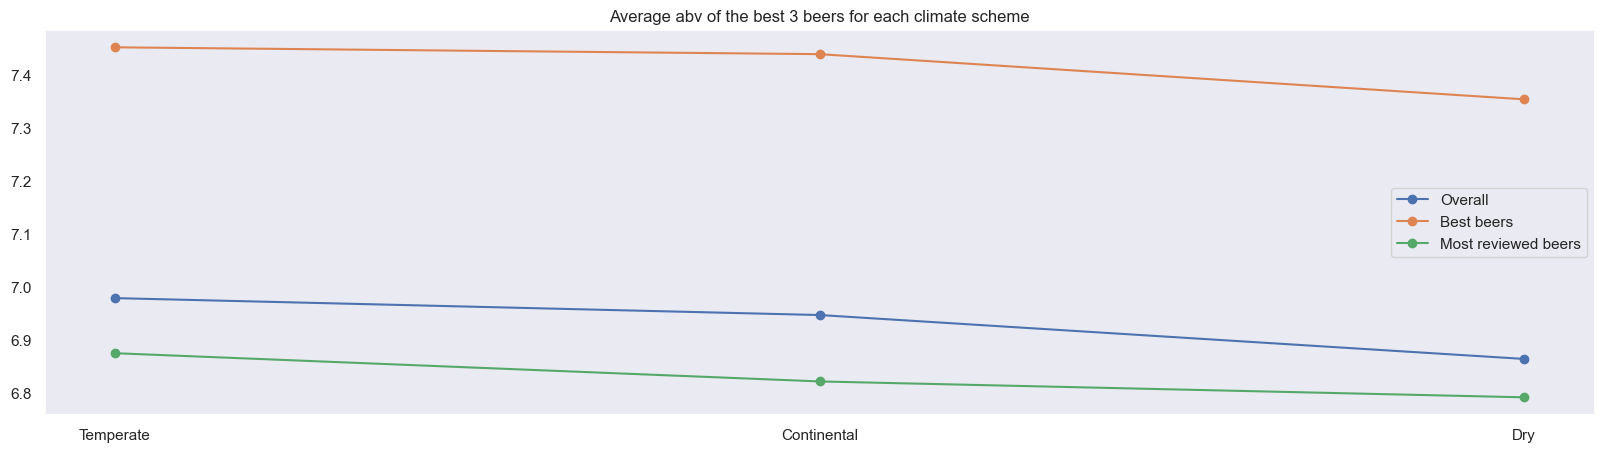

In [155]:
# Now test the climate scheme
mean_abv_overall = {}
best_beers_scheme_dfs = {}
best_beers_scheme_abv = {}
most_reviewed_scheme_dfs = {}
most_reviewed_scheme_abv = {}

for climate_s in climate_classifications["scheme"].unique():
    climate_scheme_df = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_s]
    
    mean_abv_overall[climate_s] = (climate_scheme_df["abv"] * climate_scheme_df["overall"]).sum() / climate_scheme_df["overall"].sum()
    
    us_grouped_beers = climate_scheme_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_scheme_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_scheme_dfs[climate_s] = climate_scheme_df[climate_scheme_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    best_beers_scheme_abv[climate_s] = best_beers_scheme_dfs[climate_s]["abv"].mean()
    
    most_reviewed_scheme_dfs[climate_s] = climate_scheme_df[climate_scheme_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    most_reviewed_scheme_abv[climate_s] = most_reviewed_scheme_dfs[climate_s]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([mean_abv_overall[climate_s] for climate_s in climate_classifications["scheme"].unique()], "o-", label="Overall")
ax.plot([best_beers_scheme_abv[climate_s] for climate_s in climate_classifications["scheme"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_scheme_abv[climate_s] for climate_s in climate_classifications["scheme"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["scheme"].unique())), climate_classifications["scheme"].unique())
ax.set_title("Average abv of the best 3 beers for each climate scheme")
ax.grid()
ax.legend()
plt.show()
    

In [156]:
# One-way ANOVA test for the mean abv of each climate scheme
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_scheme == zone]["abv"]
        for zone in us_abv_ratings.climate_scheme.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate scheme:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate scheme
res = stats.f_oneway(
    *[
        best_beers_scheme_dfs[zone]["abv"]
        for zone in best_beers_scheme_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate scheme
res = stats.f_oneway(
    *[
        most_reviewed_scheme_dfs[zone]["abv"]
        for zone in most_reviewed_scheme_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1])

One-way ANOVA test for the mean abv of each climate scheme: 1.035518638267342e-06
One-way ANOVA test for the mean abv of best beers of each climate scheme: 0.1294027407813918
One-way ANOVA test for the mean abv of best beers of each climate scheme: 4.981931855870337e-10


Overall average of best beers for climate without dry season: 3.9806199882371507
Overall average of most reviewed beers for climate without dry season: 3.898546323876727
Overall average of best beers for climate with dry season: 3.9530066367232015
Overall average of most reviewed beers for climate with dry season: 3.86898977277986


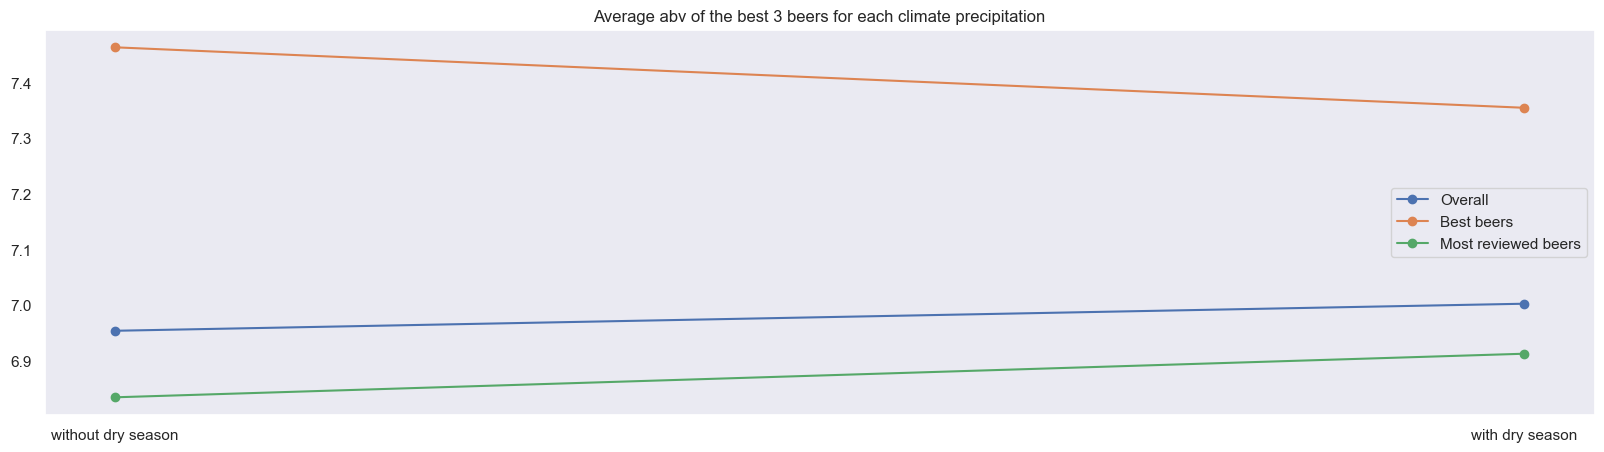

In [157]:
# Now test the climate precipitation, as there are multiple values, let's check their abv differences globally first
mean_abv_overall = {}
best_beers_precipitation_dfs = {}
best_beers_precipitation_abv = {}
most_reviewed_precipitation_dfs = {}
most_reviewed_precipitation_abv = {}

for climate_p in climate_classifications["seasonal_precipitation"].unique():
    climate_precipitation_df = us_abv_ratings[us_abv_ratings["climate_precipitation"] == climate_p]
    
    mean_abv_overall[climate_p] = (climate_precipitation_df["abv"] * climate_precipitation_df["overall"]).sum() / climate_precipitation_df["overall"].sum()
    
    us_grouped_beers = climate_precipitation_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_precipitation_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_precipitation_dfs[climate_p] = climate_precipitation_df[climate_precipitation_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    
    print("Overall average of best beers for climate {}: {}".format(climate_p, best_beers_precipitation_dfs[climate_p]["overall"].mean()))
    
    best_beers_precipitation_abv[climate_p] = best_beers_precipitation_dfs[climate_p]["abv"].mean()
    
    most_reviewed_precipitation_dfs[climate_p] = climate_precipitation_df[climate_precipitation_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    
    print("Overall average of most reviewed beers for climate {}: {}".format(climate_p, most_reviewed_precipitation_dfs[climate_p]["overall"].mean()))
    
    most_reviewed_precipitation_abv[climate_p] = most_reviewed_precipitation_dfs[climate_p]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([mean_abv_overall[climate_p] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-", label="Overall")
ax.plot([best_beers_precipitation_abv[climate_p] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_precipitation_abv[climate_p] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["seasonal_precipitation"].unique())), climate_classifications["seasonal_precipitation"].unique())
ax.set_title("Average abv of the best 3 beers for each climate precipitation")
ax.grid()
ax.legend()
plt.show()


In [158]:
# One-way ANOVA test for the mean abv of each climate precipitation
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_precipitation == zone]["abv"]
        for zone in us_abv_ratings.climate_precipitation.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate precipitation:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate precipitation
res = stats.f_oneway(
    *[
        best_beers_precipitation_dfs[zone]["abv"]
        for zone in best_beers_precipitation_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate precipitation:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation
res = stats.f_oneway(
    *[
        most_reviewed_precipitation_dfs[zone]["abv"]
        for zone in most_reviewed_precipitation_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation:", res[1])

One-way ANOVA test for the mean abv of each climate precipitation: 3.050259241881521e-07
One-way ANOVA test for the mean abv of best beers of each climate precipitation: 2.312592354731673e-14
One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation: 7.869112097673534e-13


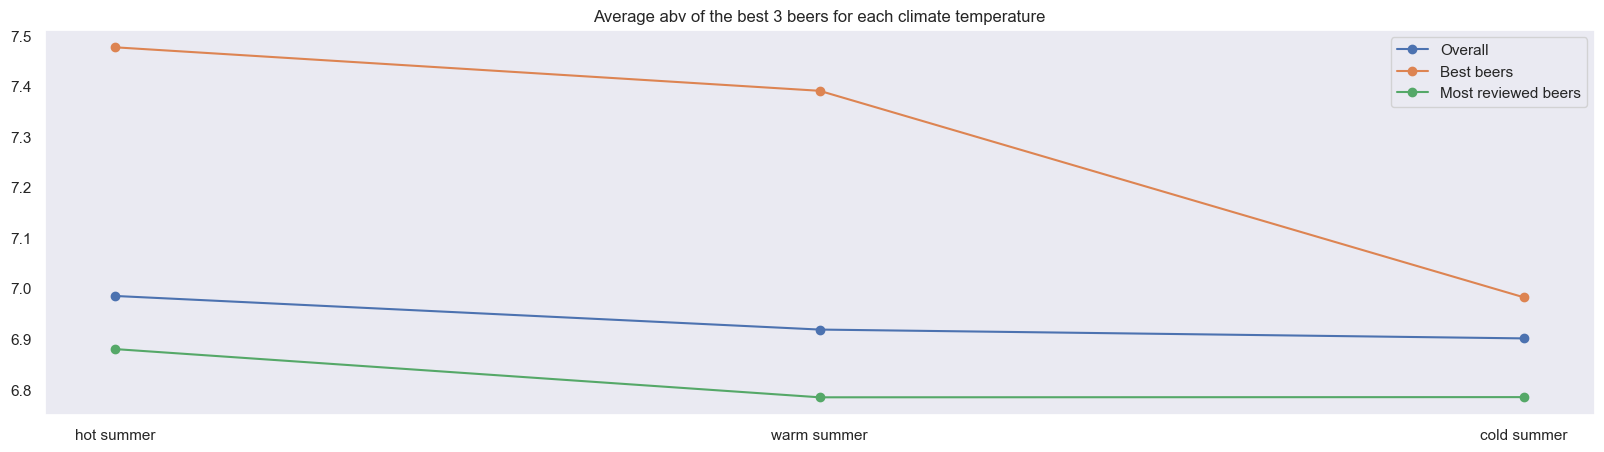

In [159]:
# Now test the climate temperature, as there are multiple values, let's check their abv differences globally first
mean_abv_overall = {}
best_beers_temperature_dfs = {}
best_beers_temperature_abv = {}
most_reviewed_temperature_dfs = {}
most_reviewed_temperature_abv = {}

for climate_t in climate_classifications["heat_level"].unique():
    climate_temperature_df = us_abv_ratings[us_abv_ratings["climate_temperature"] == climate_t]
    mean_abv_overall[climate_t] = (climate_temperature_df["abv"] * climate_temperature_df["overall"]).sum() / climate_temperature_df["overall"].sum()
    
    us_grouped_beers = climate_temperature_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_temperature_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_temperature_dfs[climate_t] = climate_temperature_df[climate_temperature_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    best_beers_temperature_abv[climate_t] = best_beers_temperature_dfs[climate_t]["abv"].mean()
    
    most_reviewed_temperature_dfs[climate_t] = climate_temperature_df[climate_temperature_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    most_reviewed_temperature_abv[climate_t] = most_reviewed_temperature_dfs[climate_t]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([mean_abv_overall[climate_t] for climate_t in climate_classifications["heat_level"].unique()], "o-", label="Overall")
ax.plot([best_beers_temperature_abv[climate_t] for climate_t in climate_classifications["heat_level"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_temperature_abv[climate_t] for climate_t in climate_classifications["heat_level"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["heat_level"].unique())), climate_classifications["heat_level"].unique())
ax.set_title("Average abv of the best 3 beers for each climate temperature")
ax.grid()
ax.legend()
plt.show()


In [160]:
# One-way ANOVA test for the mean abv of each climate temperature
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_temperature == zone]["abv"]
        for zone in us_abv_ratings.climate_temperature.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate temperature:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate temperature
res = stats.f_oneway(
    *[
        best_beers_temperature_dfs[zone]["abv"]
        for zone in best_beers_temperature_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate temperature:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature
res = stats.f_oneway(
    *[
        most_reviewed_temperature_dfs[zone]["abv"]
        for zone in most_reviewed_temperature_dfs.keys()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature:", res[1])

One-way ANOVA test for the mean abv of each climate temperature: 1.1045002846532469e-17
One-way ANOVA test for the mean abv of best beers of each climate temperature: 2.0976485596913961e-97
One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature: 1.6471394675833222e-26


## 3) Correlation between ratings and abv

In [85]:
#keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("Shape before filtering:", us_users_ratings.shape)
rating_abv_df = us_users_ratings[(us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)]
print("Shape after filtering:", rating_abv_df.shape)


Shape before filtering: (228194, 35)
Shape after filtering: (201096, 35)


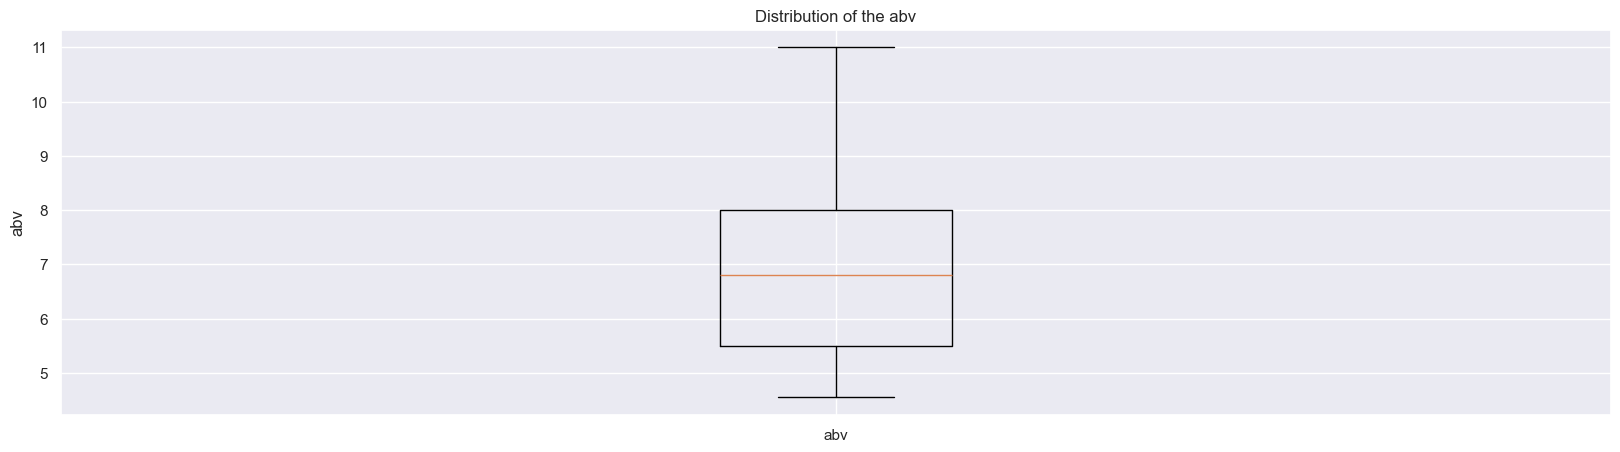

In [86]:
# Box plot of the abv
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(rating_abv_df["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

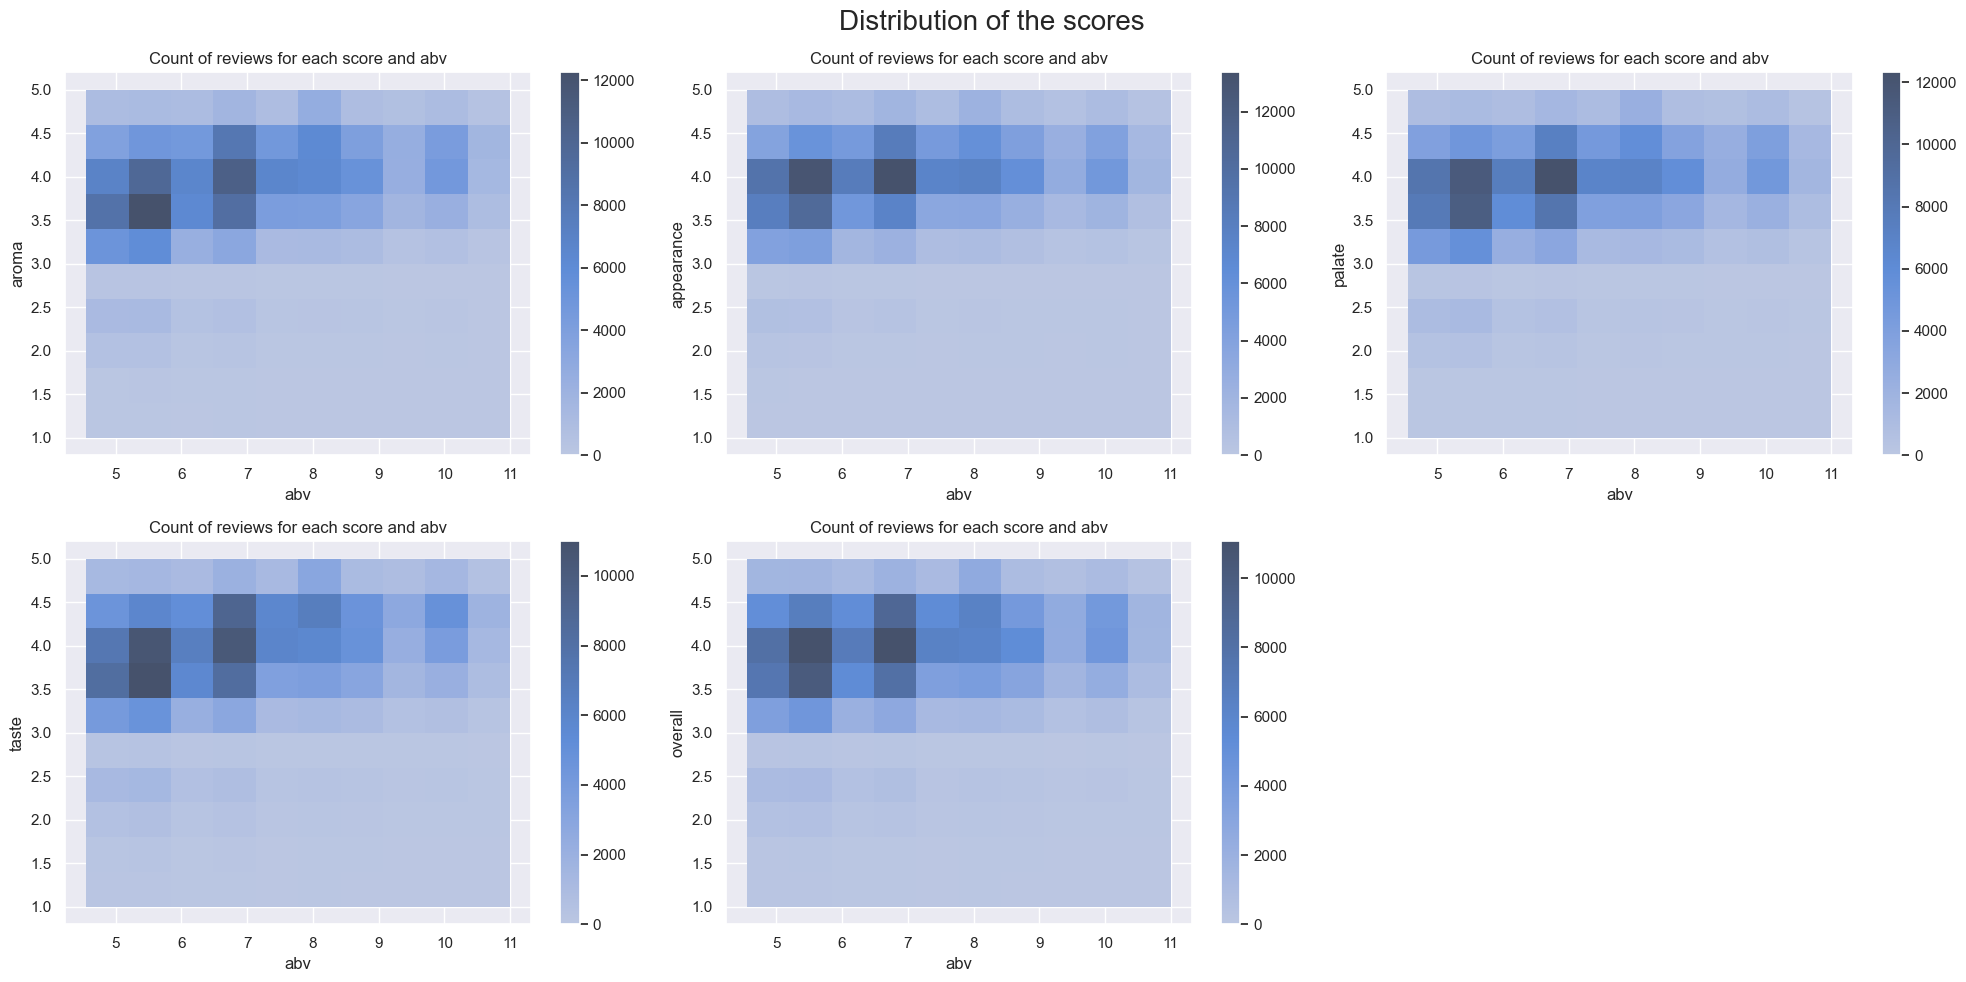

In [87]:
# 2D Histogram of the abv for each score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    
    # Heat map of the abv for each score
    sns.histplot(rating_abv_df, x="abv", y=score, bins=10, cbar=True, ax=ax)
    ax.set_title("Count of reviews for each score and abv")
    
axs[1][2].set_visible(False)

fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()